In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,y = mnist["data"] , mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


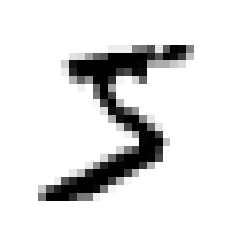

In [3]:
# 데이터의 첫번째 값의 이미지를 추출
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit =X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
# 타겟데이터를 정수형으로 변환
import numpy as np
y = y.astype(np.uint8)

In [5]:
# 데이터를 train데이터와 test데이터로 구분
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# 이진분류 준비, 5에 대하여 일치하면 T 불일치하면 F로 변환
y_train_5 = (Y_train == 5)
y_test_5 = (Y_test == 5)

In [7]:
# 확률적 경사 하강법 (SGD) 를 이용한 이진분류 
# tmi : 훈련샘플을 독립적으로 처리하기 때문에 온라인 학습에 잘 맞음
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [8]:
# 성능 측정 : 교차검증 방법 1
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96605
0.9664
0.96685


In [9]:
# 성능 측정 : 교차검증 방법 2
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,scoring="accuracy")

array([0.96885, 0.96145, 0.96625])

In [15]:
# 정확도를 분류기의 성능 지표로 선호하지 않는 이유(불균형한 데이터셋을 다룰때)

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [17]:
# 오차행렬
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[52855,  1724],
       [  933,  4488]])

In [27]:
# 정밀도와 재현율 그리고 F1score
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'정밀도 : {precision_score(y_train_5,y_train_pred)}')
print(f'재현율 : {recall_score(y_train_5,y_train_pred)}')
print(f'F1 socre : {f1_score(y_train_5,y_train_pred)}')

정밀도 : 0.7224726336123631
재현율 : 0.8278915329275042
F1 socre : 0.7715980400584544


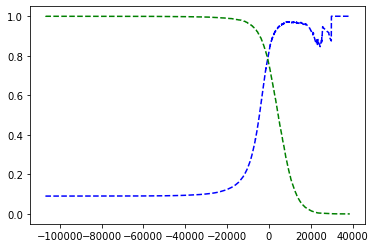

In [35]:
# 정밀도와 재현율의 트레이드오프
# 거짓 음성보다 거짓 양성이 더 중요할 때 정밀도와 재현율을 사용
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g--", label="재현율")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
    

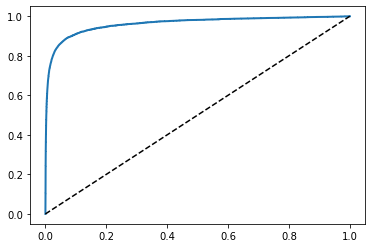

In [39]:
# roc 곡선 (1 - true nagative rate)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    
plot_roc_curve(fpr,tpr)
plt.show()